# H&M Capstone 3 project - Data Wrangling and EDA

### The business problem is classifying new products into an existing taxonomy of product categories for online retail stores such as H&M

Product category is the variable we want to predict (there are a total of 20 of them)

- Features include product title, product description, one product image per 
- Each product has a unique article ID which is set as the index of the dataframe.


#### This notebook covers the scope of data cleaning, transforming and exploratory data analysis
1. Handle missing title or image data 
2. Product variants - color
3. Convert data types into appropriate ones for machine learning
4. Select the major product categories for prediction
5. What are the most frequently occuring words in the product title and product descriptions?
6. Compare the number of images vs. the number of products and drop any rows missing an image
7. Drop null values
8. Visualizing high dimensional image embedding data
9. Look at similarities between pairs of image embeddings

## Imports

In [1]:
#pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os
from sklearn.manifold import TSNE
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from sklearn.metrics.pairwise import cosine_similarity
import random

In [3]:
MAX_DICT_SIZE = 100
MIN_PRODUCTS_PER_CATEGORY = 200

## Load the dataset

In [4]:
hm_full_df = pd.read_csv('/Users/pandabear/springboard/H_and_M_product_category_classification/data/articles.csv', index_col='article_id')
df = hm_full_df
df.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
df.info

<bound method DataFrame.info of             product_code               prod_name  product_type_no  \
article_id                                                          
108775015         108775               Strap top              253   
108775044         108775               Strap top              253   
108775051         108775           Strap top (1)              253   
110065001         110065       OP T-shirt (Idro)              306   
110065002         110065       OP T-shirt (Idro)              306   
...                  ...                     ...              ...   
953450001         953450  5pk regular Placement1              302   
953763001         953763       SPORT Malaga tank              253   
956217002         956217         Cartwheel dress              265   
957375001         957375        CLAIRE HAIR CLAW               72   
959461001         959461            Lounge dress              265   

           product_type_name  product_group_name  graphical_appearance

In [6]:
# Look at an example product description
df.loc[110065001].detail_desc

'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.'

## 1. Handle missing product title or description

In [7]:
df[['prod_name','detail_desc','product_type_name']].isnull().sum()

prod_name              0
detail_desc          416
product_type_name      0
dtype: int64

The data is not missing any product titles. Missing product descriptions is ok since it is intended to supplement the product title.

In [8]:
# replace nulls with empty strings
df.fillna('', inplace=True, axis=1)
df[['prod_name','detail_desc','product_type_name']].isnull().sum()

prod_name            0
detail_desc          0
product_type_name    0
dtype: int64

## 2. Product variants - color
How frequently do products come in color variants? While color is a defining characteristic of a product, it shouldn't affect the product category the product belongs to. 

In [9]:
df.shape

(105542, 24)

In [10]:
product_variants = df.groupby(['product_code'])['prod_name'].count()
product_variants = product_variants.sort_values(ascending=False)
product_variants[:20]

product_code
783707    75
684021    70
699923    52
699755    49
685604    46
739659    44
664074    41
570002    41
562245    41
685816    41
619739    40
695632    40
688916    39
610776    39
570003    39
620208    39
570004    39
696991    38
807241    38
674606    38
Name: prod_name, dtype: int64

In [11]:
# Look into the first product code '783707' which has 75 variants:
df[df['product_code'] == 783707]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
783707002,783707,1pk Fun,302,Socks,Socks & Tights,1010001,All over pattern,9,Black,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707004,783707,1pk Fun 1,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707005,783707,1pk Fun 1,302,Socks,Socks & Tights,1010001,All over pattern,52,Pink,3,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707012,783707,1pk Fun 1,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707015,783707,1pk Fun 1,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783707164,783707,1pk Fun,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707167,783707,1pk Fun,302,Socks,Socks & Tights,1010001,All over pattern,73,Dark Blue,4,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."
783707168,783707,1pk Fun,302,Socks,Socks & Tights,1010001,All over pattern,93,Dark Green,2,...,Socks Wall,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,"Socks in a soft, jacquard-knit cotton blend wi..."


In [12]:
# Look at the description of these socks to see if they are the same
df[df['product_code'] == 783707].detail_desc.unique()

array(['Socks in a soft, jacquard-knit cotton blend with elasticated tops.'],
      dtype=object)

In [13]:
# Look at the color variants of the socks
df[df['product_code'] == 783707].colour_group_name.unique()

array(['Black', 'Dark Blue', 'Pink', 'Red', 'Light Green', 'Turquoise',
       'Grey', 'Light Grey', 'Dark Purple', 'Blue', 'Dark Turquoise',
       'Dark Grey', 'Purple', 'Light Blue', 'Dark Green', 'Orange',
       'Beige', 'Light Purple', 'Greenish Khaki', 'White', 'Light Yellow',
       'Light Turquoise', 'Dark Orange'], dtype=object)

This shows that the product '1pk Fun 1' or '1pk Fun' are socks that come in a variety of colors. For the purposes of product category classification, the 75 variants can be treated as a single product. 

### How many color variants are there across all products?

In [14]:
unique_colors = len(df['colour_group_name'].unique())
print(f'There are a total of {unique_colors} unique colors')


There are a total of 50 unique colors


In [15]:
color_counts = df.groupby('colour_group_name').count()['prod_name'].reset_index().sort_values(by='prod_name', ascending=False)
color_counts

,colour_group_name,prod_name
1,Black,22670
5,Dark Blue,12171
47,White,9542
24,Light Pink,5811
17,Grey,4487
19,Light Beige,3356
2,Blue,3308
42,Red,3056
20,Light Blue,3012
16,Greenish Khaki,2767


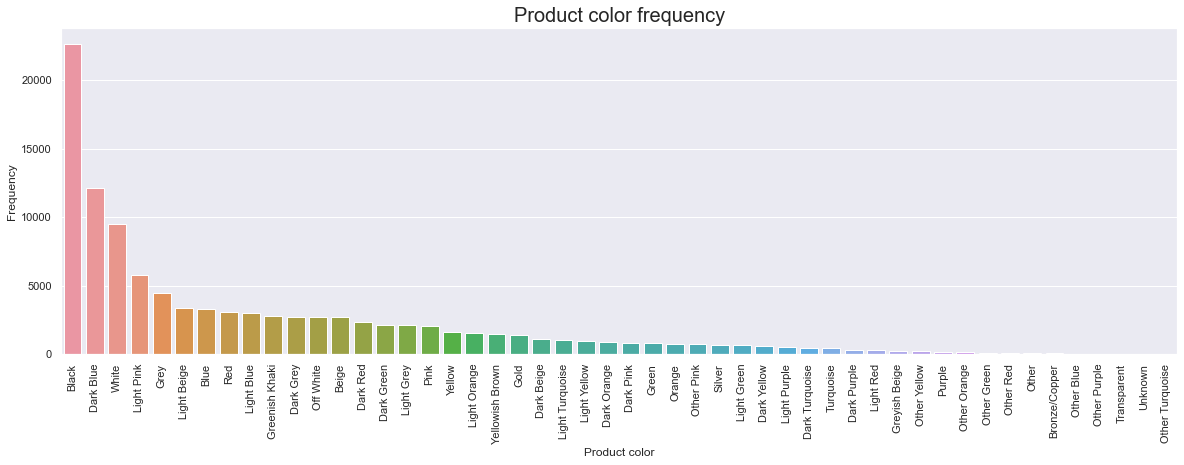

In [16]:
# Plot a barplot of this color frequency
ax = sns.set(rc={"figure.figsize":(20, 6)})
ax = sns.barplot(x='colour_group_name', y='prod_name', data=color_counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel ="Product color", ylabel = "Frequency")
ax.set_title('Product color frequency', size = 20)
plt.show()

The most common colors are neutral colors and black is the most frequently occuring product color. 

### Keep the color variants so image classification has more to learn from, but don't include color as a feature. 
A difference in color does not add any new information about the product to product category classification. The column 'product_code' is the same for all color variants of the same product. 


## 3. Convert data types into appropriate ones for machine learning

In [17]:
df[['prod_name','detail_desc','product_type_name']].dtypes

prod_name            object
detail_desc          object
product_type_name    object
dtype: object

In [18]:
# Convert object dtype to string
df[['prod_name','detail_desc','product_type_name']] = df[['prod_name','detail_desc','product_type_name']].astype("string")

In [19]:
df[['prod_name','detail_desc','product_type_name']].dtypes

prod_name            string
detail_desc          string
product_type_name    string
dtype: object

## 4. Select the major product categories for prediction
### The target variable is the product categories column 'product_type_name'
Group by 'product_code' and only keep the first row if there are color variants

In [20]:
no_color_variants = df.groupby('product_code').first()

In [21]:
# Look at the product categories and how often they appear
print(f'There are {len(no_color_variants.product_type_name.unique())} unique product categories')
no_color_variants['product_type_name'].value_counts()

There are 126 unique product categories


Dress            5542
Trousers         4701
Sweater          3602
Jacket           2305
T-shirt          2149
                 ... 
Washing bag         1
Shoulder bag        1
Cushion             1
Blanket             1
Clothing mist       1
Name: product_type_name, Length: 126, dtype: Int64

In [22]:
type_list = no_color_variants.product_type_name.value_counts().reset_index()
# Select only major categories that have more than the variable 'MIN_PRODUCTS_PER_CATEGORY'
major_categories = type_list[type_list.product_type_name > MIN_PRODUCTS_PER_CATEGORY]['index']
list(major_categories)
print(f'There are a total of {len(major_categories)} major product categories')

There are a total of 44 major product categories


In [23]:
type_list[type_list.product_type_name > MIN_PRODUCTS_PER_CATEGORY]

,index,product_type_name
0,Dress,5542
1,Trousers,4701
2,Sweater,3602
3,Jacket,2305
4,T-shirt,2149
5,Blouse,2054
6,Top,1860
7,Skirt,1577
8,Shorts,1546
9,Shirt,1344


Manually combine several of the categories that should belong together:

In [24]:
categories_dict = {'Accessories': ['Other accessories', 'Hair/alice band', 'Gloves', 'Belt', 'Sunglasses', 'Scarf'],
                   'Jewelry':['Necklace', 'Earring'],
                   'Hat':['Hat/beanie', 'Hat/brim', 'Cap/peaked'],
                   'Shoes':['Other shoe', 'Sandals', 'Boots', 'Sneakers'],
                   'Swimwear':['Swimwear bottom', 'Swimsuit', 'Bikini top'],
                   'Full length':['Jumpsuit/Playsuit', 'Dungarees', 'Garment Set'],
                    'Underwear/PJs':['Underwear bottom', 'Underwear Tights', 'Bra', 'Pyjama set'],
                   'Outerwear':['Jacket', 'Hoodie', 'Blazer', 'Coat'],
                   'Sweater/Cardigan/Vest':['Sweater', 'Cardigan', 'Vest top'],
                   'Socks/Tights':['Socks', 'Tights', 'Leggings/Tights']
                  }

In [25]:
# Create a mask to combine categories
for category in categories_dict:
    df['product_type_name'].mask(df['product_type_name'].isin(categories_dict[category]),category,inplace=True)


In [26]:
no_color_variants = df.groupby('product_code').first()
type_list = no_color_variants.product_type_name.value_counts().reset_index()
# Select only major categories that have more than the variable 'MIN_PRODUCTS_PER_CATEGORY'
major_categories = type_list[type_list.product_type_name > MIN_PRODUCTS_PER_CATEGORY]['index']
list(major_categories)
print(f'There are a total of {len(major_categories)} major product categories')
type_list[type_list.product_type_name > MIN_PRODUCTS_PER_CATEGORY]

There are a total of 20 major product categories


,index,product_type_name
0,Dress,5542
1,Sweater/Cardigan/Vest,5404
2,Trousers,4701
3,Outerwear,3939
4,Accessories,2339
5,Underwear/PJs,2283
6,T-shirt,2149
7,Blouse,2054
8,Shoes,2007
9,Top,1860


In [27]:
df = df[df.product_type_name.isin(major_categories)]
df.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Sweater/Cardigan/Vest,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Sweater/Cardigan/Vest,Garment Upper body,1010016,Solid,10,White,3,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Sweater/Cardigan/Vest,Garment Upper body,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,OP T-shirt (Idro),306,Underwear/PJs,Underwear,1010016,Solid,9,Black,4,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,OP T-shirt (Idro),306,Underwear/PJs,Underwear,1010016,Solid,10,White,3,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [28]:
df['product_type_name'].unique()

<StringArray>
['Sweater/Cardigan/Vest',         'Underwear/PJs',          'Socks/Tights',
                   'Top',              'Trousers',              'Bodysuit',
             'Outerwear',           'Accessories',                 'Shoes',
              'Swimwear',                 'Skirt',               'T-shirt',
                 'Dress',                   'Hat',                'Shorts',
                 'Shirt',               'Jewelry',                   'Bag',
           'Full length',                'Blouse']
Length: 20, dtype: string

In [29]:
# Represent the product categories as a percentage
class_percentages = pd.DataFrame([(x / df.shape[0]) * 100.00 for x in df.product_type_name.value_counts()], index=df.product_type_name.value_counts().index)
class_percentages.columns = ['Percentage']
class_percentages = class_percentages.reset_index()
class_percentages

,index,Percentage
0,Sweater/Cardigan/Vest,13.883958
1,Trousers,11.202046
2,Dress,10.392658
3,T-shirt,7.927386
4,Outerwear,7.889273
5,Underwear/PJs,6.645605
6,Accessories,4.359862
7,Top,4.167294
8,Blouse,3.990773
9,Shorts,3.950654


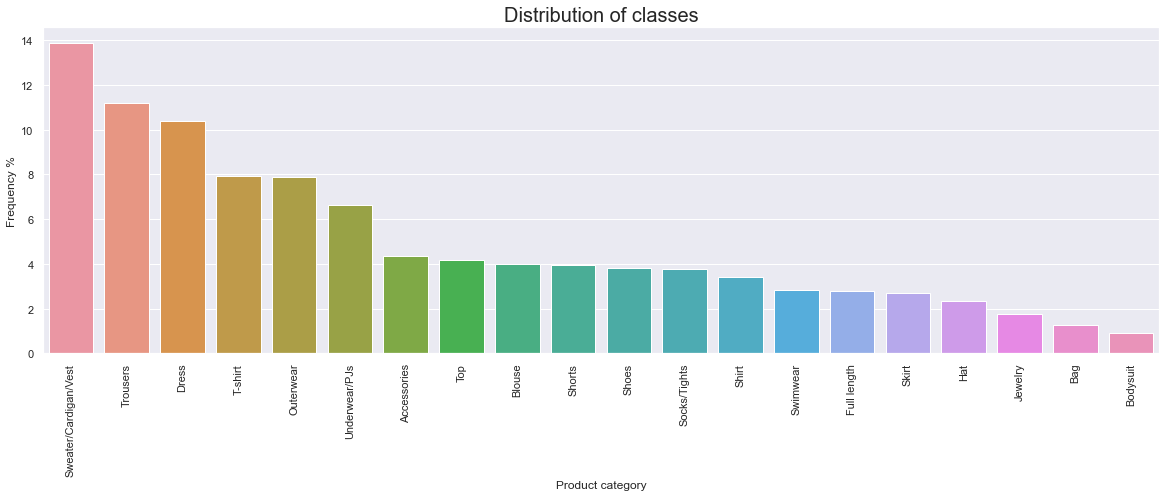

In [30]:
# Plot the distribution of product categories
ax = sns.set(rc={"figure.figsize":(20, 6)})
ax = sns.barplot(x='index', y='Percentage', data=class_percentages)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel ="Product category", ylabel = "Frequency %")
ax.set_title('Distribution of classes', size = 20)
plt.show()

The most frequently occuring product category 'Trousers' and makes up 11% of the product categories, which means that guessing the category 'Trousers' should be correct 11% of the time. 

## 5. What are the most frequently occuring words in the product title and product descriptions? 
Plot some word clouds to visualize the top words

In [31]:
def plot_wordcloud(text):
    stopwords = set(STOPWORDS)
    WordCloud().generate(text)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1000, height=800).generate(text)
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

There are 1642117 words in the combination in column prod_name


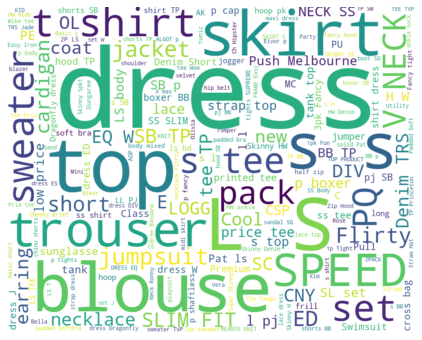

In [32]:
# Create a text list of all words in column 'prod_name'
title_text = " ".join(word for word in df.prod_name.astype(str))
print(f'There are {len(title_text)} words in the combination in column prod_name')
plot_wordcloud(title_text)

There are 14291364 words in the combination in column detail_desc


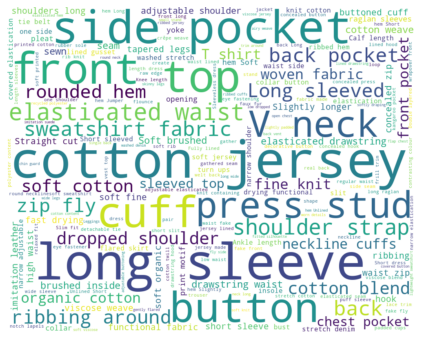

In [33]:
# Create a text list of all words in column 'detail_desc'
desc_text = " ".join(word for word in df.detail_desc.astype(str))
print(f'There are {len(desc_text)} words in the combination in column detail_desc')
plot_wordcloud(desc_text)

Word clouds of the most frequently occuring words in the product title and product descriptions show few similar results in each, but the product description word cloud shows more adjectives about fabric and clothing attributes than nouns to describe what the product is. Thus, I suspect product title would have more information about the product category than the clothing attributes as they could apply to multiple different categories.

### Look at distributions of words in the product titles feature

In [34]:
# Split the strings in product title 
df['product_title'] = df['prod_name'].apply(lambda x: x.lower()).apply(lambda y: y.split())
df['product_title']

/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_17400/3307406989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_title'] = df['prod_name'].apply(lambda x: x.lower()).apply(lambda y: y.split())


article_id
108775015                  [strap, top]
108775044                  [strap, top]
108775051             [strap, top, (1)]
110065001         [op, t-shirt, (idro)]
110065002         [op, t-shirt, (idro)]
                        ...            
952938001                  [elton, top]
953450001    [5pk, regular, placement1]
953763001         [sport, malaga, tank]
956217002            [cartwheel, dress]
959461001               [lounge, dress]
Name: product_title, Length: 99705, dtype: object

In [103]:
# cat_title_count = {}
# #product_title_counter = Counter()

# # Use stemming for category names and product titles
# ps = PorterStemmer()
# major_categories_stem = []
# for cat in major_categories:
#     major_categories_stem.append(ps.stem(cat.lower()))

# # Iterate over the major product categories and use a counter for the number of times the stem of the title matches the category
# for i, cat in enumerate(major_categories):
#     # compile a single list of product titles for each product category
#     titles = df[df['product_type_name'] == cat]['product_title'].tolist()
#     cat_titles = [item for sublist in titles for item in sublist]
#     title_stem = []
#     # create stem of product titles
#     for title in cat_titles:
#         title_stem.append(ps.stem(title))
#     counter = Counter(title_stem)
#     # Compare product category to the product title counter and output how many times they match
#     cat_title_count[major_categories[i]] = counter[major_categories_stem[i]]
    

In [124]:
ps = PorterStemmer()

def stem(str):
    str = str.lower()
    str = str.replace('-', '')
    words = re.compile(r' |\/').split(str)
    return [ps.stem(w) for w in words]

In [125]:
cat_title_count = {}

# Use stemming for category names and product titles
major_categories_stem = {}
for cat in major_categories:
    for word in stem(cat):
        major_categories_stem[word] = cat

print(major_categories_stem)

cat_title_count = {cat: 0 for cat in major_categories}
for i, row in df.iterrows():
    stemmed_title = stem(row.prod_name)
    cats = set()
    for word in stemmed_title:
        if word in major_categories_stem:
            cats.add(major_categories_stem[word])
    for cat in cats:
        cat_title_count[cat] += 1
    
print(cat_title_count)

{'dress': 'Dress', 'sweater': 'Sweater/Cardigan/Vest', 'cardigan': 'Sweater/Cardigan/Vest', 'vest': 'Sweater/Cardigan/Vest', 'trouser': 'Trousers', 'outerwear': 'Outerwear', 'accessori': 'Accessories', 'underwear': 'Underwear/PJs', 'pj': 'Underwear/PJs', 'tshirt': 'T-shirt', 'blous': 'Blouse', 'shoe': 'Shoes', 'top': 'Top', 'full': 'Full length', 'length': 'Full length', 'skirt': 'Skirt', 'short': 'Shorts', 'shirt': 'Shirt', 'jewelri': 'Jewelry', 'swimwear': 'Swimwear', 'hat': 'Hat', 'sock': 'Socks/Tights', 'tight': 'Socks/Tights', 'bag': 'Bag', 'bodysuit': 'Bodysuit'}
{'Dress': 7774, 'Sweater/Cardigan/Vest': 3147, 'Trousers': 1514, 'Outerwear': 0, 'Accessories': 0, 'Underwear/PJs': 858, 'T-shirt': 628, 'Blouse': 1774, 'Shoes': 131, 'Top': 3881, 'Full length': 27, 'Skirt': 1894, 'Shorts': 3638, 'Shirt': 1947, 'Jewelry': 1, 'Swimwear': 0, 'Hat': 306, 'Socks/Tights': 1917, 'Bag': 655, 'Bodysuit': 3}


In [126]:
cat_title_df = pd.DataFrame([cat_title_count]).T.reset_index()
cat_title_df.columns = ['product_category','number_of_matches']
cat_title_df.sort_values(by='number_of_matches', ascending=False, inplace=True)
cat_title_df


,product_category,number_of_matches
0,Dress,7774
9,Top,3881
12,Shorts,3638
1,Sweater/Cardigan/Vest,3147
13,Shirt,1947
17,Socks/Tights,1917
11,Skirt,1894
7,Blouse,1774
2,Trousers,1514
5,Underwear/PJs,858


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Dress'),
  Text(1, 0, 'Top'),
  Text(2, 0, 'Shorts'),
  Text(3, 0, 'Sweater/Cardigan/Vest'),
  Text(4, 0, 'Shirt'),
  Text(5, 0, 'Socks/Tights'),
  Text(6, 0, 'Skirt'),
  Text(7, 0, 'Blouse'),
  Text(8, 0, 'Trousers'),
  Text(9, 0, 'Underwear/PJs'),
  Text(10, 0, 'Bag'),
  Text(11, 0, 'T-shirt'),
  Text(12, 0, 'Hat'),
  Text(13, 0, 'Shoes'),
  Text(14, 0, 'Full length'),
  Text(15, 0, 'Bodysuit'),
  Text(16, 0, 'Jewelry')])

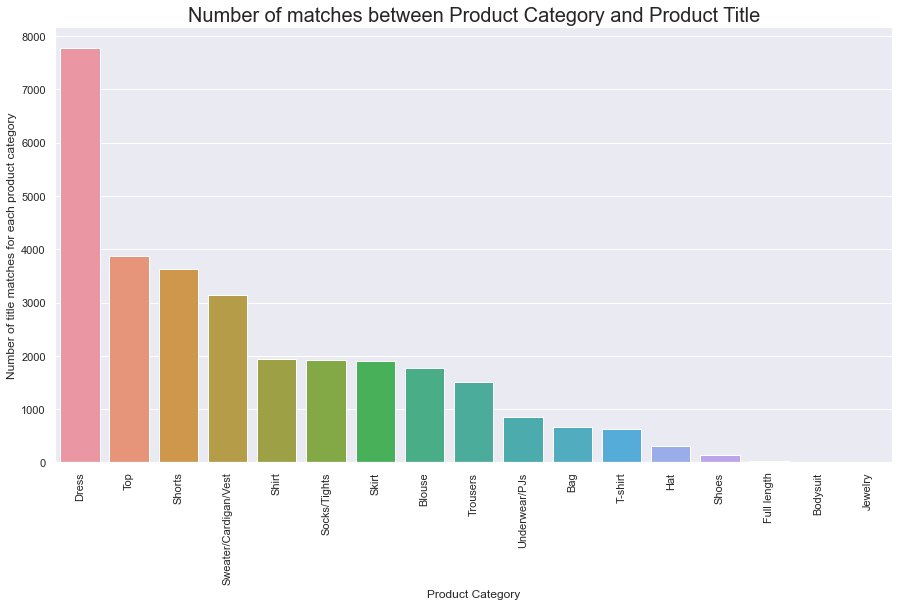

In [127]:
# Plot the number of matches
cat_title_nonzero = cat_title_df[cat_title_df['number_of_matches'] != 0]
fig = plt.figure(figsize=(15, 8))
chart = sns.barplot(data=cat_title_nonzero, x='product_category', y='number_of_matches')
chart.set_title('Number of matches between Product Category and Product Title', fontdict={'size':20})
plt.xlabel('Product Category')
plt.ylabel('Number of title matches for each product category')
plt.xticks(rotation=90)


In [38]:
# As a percentage of the products in each category
category_count = pd.DataFrame(df.groupby('product_type_name')['prod_name'].count()).reset_index()
title_category_percentage = cat_title_nonzero.merge(category_count,how="left",left_on="product_category", right_on='product_type_name')
title_category_percentage['perc_matches'] = title_category_percentage['number_of_matches']/title_category_percentage['prod_name']*100


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Dress'),
  Text(1, 0, 'Shorts'),
  Text(2, 0, 'Skirt'),
  Text(3, 0, 'Shirt'),
  Text(4, 0, 'Blouse'),
  Text(5, 0, 'Trousers'),
  Text(6, 0, 'Top'),
  Text(7, 0, 'Bag'),
  Text(8, 0, 'T-shirt'),
  Text(9, 0, 'Hat'),
  Text(10, 0, 'Shoes'),
  Text(11, 0, 'Jewelry')])

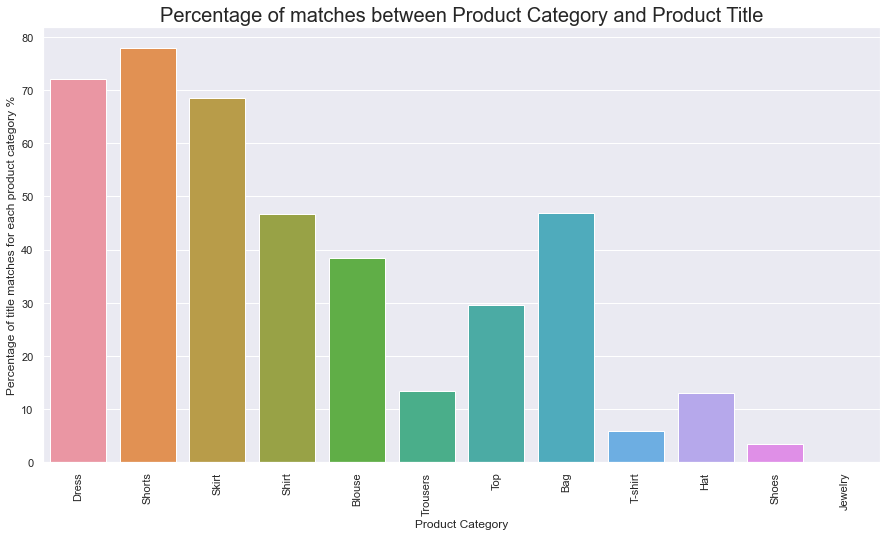

In [39]:
# Only plot the ones that are non zero
fig = plt.figure(figsize=(15, 8))
chart = sns.barplot(data=title_category_percentage, x='product_category', y='perc_matches')
chart.set_title('Percentage of matches between Product Category and Product Title', fontdict={'size':20})
plt.xlabel('Product Category')
plt.ylabel('Percentage of title matches for each product category %')
plt.xticks(rotation=90)


This bar graph shows that there are many product categories that have the name repeated in the product title. For some categories such as 'Shorts' this occurs more than 75% of the time, which is so high these categories could use it's own title as the algorithm for predicting product category. Other product categories such as Trousers are a lot less likely to have the word repeated in the product title. 
I propose to build several models using image embeddings and/or product text (title and description) to determine which is the best combination of features to use. Categories with a high overlap between product title and category could use the results of this stemming word match as a baseline model.

### Import image embeddings csv file
Due to the large number of images, the image embeddings were created in a separate jupyter notebook and done in batches and combined into a single dataframe. See the notebook here: [image embeddings notebook](https://github.com/melissavhan/H_and_M_product_category_classification/blob/03124bd14a6cc408ccabdb1301038b70dfa5ac58/notebooks/Capstone%203%20-%20Image%20embedding.ipynb)

ResNet-34 from the 'Deep Residual Learning for Image Recognition' research paper was used, along with the pretrained model weights. This model includes up to 152 layers. Since the image embedding evaluation was done on a laptop, a simpler neural net model was chosen as other higher numbered ResNet models would have taken longer to evaluate. 

Proprocessing image steps were setup to be the same as the training steps for the ResNet-34 model:
1. Resize the image to a square measuring 256 pixels by 256 pixels
2. CenterCrop to 224 pixels
3. Convert image to a Tensor
4. Normalize the tensor image with mean and standard deviation

The image mode for this model is RGB, and if the image is Greyscale, it is converted to RGB. 

In [40]:
# Open the image embeddings csv file
image_embedding = pd.read_csv('/Users/pandabear/springboard/H_and_M_product_category_classification/data/interim/combined_image_embeddings.csv', index_col='Unnamed: 0')
# Rename index to 'article_id' so it is consistent with the original dataset
image_embedding.index.names = ['article_id']
# Drop extra column
image_embedding.drop(['Unnamed: 0.1'], axis=1, inplace=True)


In [41]:
image_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
217207047,2.679361,0.306564,1.212155,1.188260,0.056715,0.022303,1.147643,0.293646,0.605903,0.052473,...,0.674172,1.723143,0.104001,0.674032,1.619033,0.617591,0.405708,0.362968,0.493930,2.490882
213691080,0.632062,0.070936,1.370101,3.107503,0.912835,0.019927,0.017866,0.426144,0.084189,0.150863,...,2.272056,0.204228,0.337832,0.126854,0.394283,1.328873,0.304165,0.058076,0.985178,0.030038
212629036,1.380411,0.093138,0.224101,0.026163,0.569458,0.200051,0.257274,0.116943,0.425302,0.499474,...,1.543374,0.145237,0.746950,0.624660,0.352762,0.159102,0.097694,1.121258,0.312964,0.272676
214844001,1.017763,0.094177,2.294733,1.414627,0.029835,1.086756,1.917363,0.509459,0.117570,0.075120,...,3.446632,1.106723,0.128347,1.110429,0.588763,0.000299,0.630921,0.190633,1.509852,3.986516
216081011,0.228950,0.253633,0.134512,0.161084,0.621370,0.850047,2.252668,1.000498,0.221402,0.535628,...,1.135270,0.017909,0.772394,0.775876,3.701260,0.668516,0.094508,0.876413,1.510044,1.602928


In [42]:
image_embedding.shape

(105100, 512)

In [43]:
df.shape

(99705, 25)

## 7. Compare the number of images vs. the number of products
Each product should have a corresponding product image

In [44]:
# Check the number of images in file directory vs. the number of products under article_id?
# Do a left join to see which rows are missing images
combineddf = df.join(image_embedding, how="left", on="article_id")
# Select the rows where there is product text but no image
combineddf[combineddf['511'].isnull() == True]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,
179208001,179208,Control Top 100 den 1p Tights,273,Socks/Tights,Garment Lower body,1010016,Solid,9,Black,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212042043,212042,Mimmi sneaker,94,Shoes,Shoes,1010016,Solid,9,Black,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212042066,212042,Mimmi sneaker,94,Shoes,Shoes,1010016,Solid,22,Yellow,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212629004,212629,Alcazar strap dress,265,Dress,Garment Full body,1010016,Solid,9,Black,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215324023,215324,Classic Fancy pilot (1),81,Accessories,Accessories,1010016,Solid,6,Light Grey,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877369001,877369,CHERRY JRSY,275,Skirt,Garment Lower body,1010004,Check,9,Black,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880333001,880333,Violet LS,254,Top,Garment Upper body,1010016,Solid,10,White,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901588001,901588,Barbie Dress,265,Dress,Garment Full body,1010006,Dot,51,Light Pink,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Save a list of the article_id products that are missing images
missing_images = list(combineddf[combineddf['511'].isnull() == True].index)

print(f'There are a total of {len(missing_images)} images missing from the dataset')
# Since this is a small fraction of the dataset, drop these rows from the dataset. 
df.drop(index=missing_images, inplace=True)

There are a total of 373 images missing from the dataset


/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_17400/1875852106.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=missing_images, inplace=True)


In [46]:
# Do a left join to see which rows are missing images
combineddf_1 = df.join(image_embedding, how="left", on="article_id")
# Select the rows where there is product text but no image
combineddf_1[combineddf_1['511'].isnull() == True]

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,502,503,504,505,506,507,508,509,510,511
article_id,,,,,,,,,,,,,,,,,,,,,


All rows have an associated image

## 6. Drop null values

In [47]:
combineddf.isna().sum()

product_code            0
prod_name               0
product_type_no         0
product_type_name       0
product_group_name      0
                     ... 
507                   373
508                   373
509                   373
510                   373
511                   373
Length: 537, dtype: int64

In [48]:
combineddf.dropna(inplace=True)
combineddf.isna().sum()

product_code          0
prod_name             0
product_type_no       0
product_type_name     0
product_group_name    0
                     ..
507                   0
508                   0
509                   0
510                   0
511                   0
Length: 537, dtype: int64

## 8. Visualizing high dimensional image embedding data
### Use t-SNE to do dimensionality reduction to 2, so it can be plotted on a scatterplot

In [49]:
# Left join the image embedding df with the dataset to add product categories as a column
combined_image_embedding = image_embedding.join(df.product_type_name, how="left", on="article_id")

# Select only the rows that have product categories in the major_categories list
combined_image_embedding = combined_image_embedding[combined_image_embedding.product_type_name.isin(major_categories)]

# Group by product category and average columns
image_embedding_avg = combined_image_embedding.groupby('product_type_name').mean()
category_name = image_embedding_avg.index
image_embedding_avg.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
product_type_name,,,,,,,,,,,,,,,,,,,,,
Accessories,0.692386,0.298825,0.554115,1.330640,0.834550,0.750072,0.883507,0.622461,0.377995,0.510592,...,1.133046,1.166119,0.500574,0.534781,0.585224,1.577991,0.593178,0.650000,1.227887,0.817168
Bag,0.681212,0.443677,0.403611,0.931738,1.246021,1.551660,0.513118,1.334101,0.449637,0.420068,...,1.098513,1.420103,0.448688,0.636952,0.311516,0.857420,0.793789,0.630510,1.335264,1.001545
Blouse,0.744832,0.166796,0.467158,0.633646,0.457992,0.507452,1.250333,0.351339,0.539323,0.384185,...,1.086174,0.545895,0.604049,0.574052,2.798644,0.745973,0.598790,0.747050,0.584612,1.490449
Bodysuit,1.181094,0.159809,0.693171,1.107100,0.395856,0.327650,0.978300,0.440608,0.618275,0.419013,...,0.751019,0.999081,0.416543,0.508286,3.012955,1.066656,0.670635,0.842504,0.727294,1.401361
Dress,1.173610,0.212675,0.735122,0.532073,0.383241,0.373241,1.317777,0.273734,0.487159,0.303162,...,0.971677,0.488829,0.884705,0.576817,2.296170,0.496446,0.459986,0.945177,0.718282,1.063060


In [61]:
# Use t-SNE to do dimensionality reduction to 2 
model = TSNE(n_components=2,perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(image_embedding_avg)
print(tsne_data.shape)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(20, 2)


In [62]:
# Let's look at the top 20 major product categories
tsne_data = pd.DataFrame(tsne_data[:20])
tsne_data.columns = ['Dimension_1', 'Dimension_2']
tsne_data

,Dimension_1,Dimension_2
0,-104.681000,-10.940772
1,-6.670299,-16.241014
2,-51.206478,-60.333103
3,-79.880943,-18.265486
4,-32.368973,28.019173
5,-17.885979,-42.740833
6,-104.719078,16.948822
7,-30.098431,-16.281174
8,-58.684757,19.007671
9,-97.241646,-36.259087


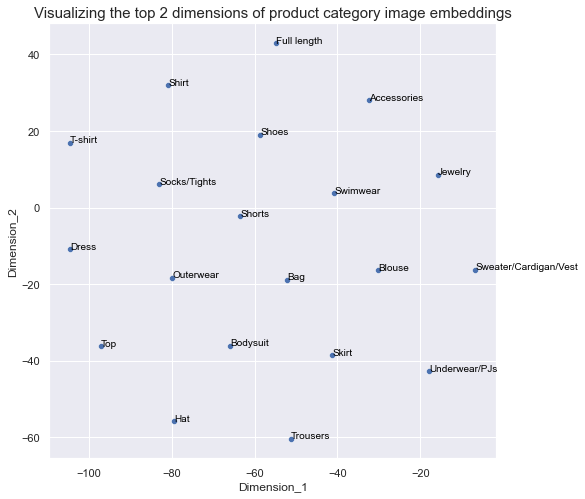

In [63]:
# Plot as scatterplot each product category and the categories that are close to each other should be similar in distance
sns.set(rc={"figure.figsize":(8, 8)})
chart = sns.scatterplot(data=tsne_data, x='Dimension_1', y='Dimension_2')
chart.set_title('Visualizing the top 2 dimensions of product category image embeddings', fontdict={'size':15})
for i in range(tsne_data.shape[0]):
    plt.text(x=tsne_data['Dimension_1'][i]+0.03, y=tsne_data['Dimension_2'][i]+0.03, s=major_categories[i], 
          fontdict=dict(color='black',size=10))


The scatterplot shoes some clustering of product categories such as top, hoodie, blouse. But there are other categories that don't seem to have a relationship such as socks, dress, shorts.

### Use t-SNE to do dimensionality reduction to 3, so it can be plotted on a 3-D scatterplot

In [69]:
# Use t-SNE to do dimensionality reduction to 3
model3 = TSNE(n_components=3,perplexity=50, n_iter=5000)
tsne_data3 = model3.fit_transform(image_embedding_avg)
print(tsne_data3.shape)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(20, 3)


In [70]:
tsne_data3 = pd.DataFrame(tsne_data3)
tsne_data3.columns = ['Dimension_1', 'Dimension_2', 'Dimension_3']
tsne_data3['cmap'] = ['yellow','gold','pink','tomato','red','coral',
                      'orange','darkviolet','sienna','green','yellowgreen','brown',
                      'magenta','silver','hotpink','plum','limegreen','blue','dodgerblue','navy']
tsne_data3.index = category_name
tsne_data3.shape

(20, 4)

In [71]:
tsne_data3

,Dimension_1,Dimension_2,Dimension_3,cmap
product_type_name,,,,
Accessories,-399.133942,209.957779,476.183044,yellow
Bag,42.030628,-637.465759,-584.843811,gold
Blouse,-17.384291,599.442566,-440.344025,pink
Bodysuit,5.739916,-15.780907,-245.936737,tomato
Dress,582.293030,-150.382156,620.718506,red
Full length,-19.879135,-55.758842,824.339905,coral
Hat,-652.206177,488.813751,-510.355377,orange
Jewelry,-360.315247,-433.659332,376.856323,darkviolet
Outerwear,163.971024,24.835684,250.941605,sienna


There are 18 major categories, each of which is represented by a x,y,z coordinate. 

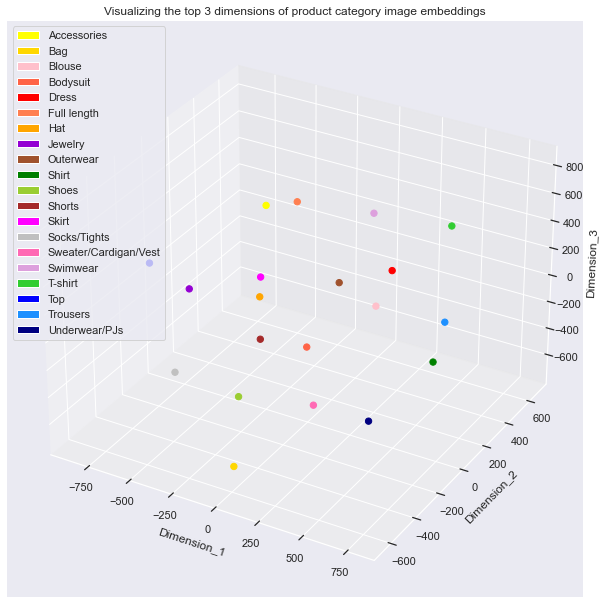

In [72]:
# Plot a 3D scatterplot for each product category. Categories that are close to each other should be similar in distance

# axes instance
fig = plt.figure(figsize=(20,8))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

sc = ax.scatter(tsne_data3['Dimension_1'], tsne_data3['Dimension_2'], tsne_data3['Dimension_3'], s=40, c=tsne_data3['cmap'], marker='o', alpha=1)
ax.set_xlabel('Dimension_1')
ax.set_ylabel('Dimension_2')
ax.set_zlabel('Dimension_3')
ax.set_title('Visualizing the top 3 dimensions of product category image embeddings')

recs = []
for i in range(0, tsne_data3.shape[0]):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=tsne_data3['cmap'][i]))
plt.legend(recs, tsne_data3.index, loc=2)

There seems to be clusters of similar product categories: full length is in the middle, bottoms are on the left hand side. Accessories are clustered together, but could be further separated into its own subcategories. 

## 9. Look at similarities between pairs of image embeddings

### There are 3 groups:
Group 1: Products that are the same but different color variants share the same 'product_code' and should have the most similar image embeddings.

Group 2: Products that are similar and in the same product category have different 'product_code' and the same 'product_type_name'.

Group 3: Products that are in different categories should have the least similarity between image embeddings. 

In [73]:
# The image embedding column names are stored in a list
image_cols = [str(num) for num in range(512)]

### Group 1: Products that color variants of each other but are essentially the same product

In [74]:
# Group 1
color_versions = combineddf.groupby(by='product_code')['prod_name'].count()
multiple_versions = color_versions[color_versions > 1]
multiple_versions_list = list(multiple_versions.index)

# Select top 1000 products that have color variants
group1 = multiple_versions_list[:1000]

In [75]:
group1_cos_sim = []

for num in group1:
    result = combineddf[combineddf['product_code'] == num][image_cols]
    # Take the cosine similarity between rows 1 and 2 
    group1_cos_sim.append(cosine_similarity(result.iloc[:2,:])[1][0])

### Group 2: Products that are in the same product category but are not color variants

In [76]:
# Group 2
color_versions = combineddf.groupby(by='product_code')['prod_name'].count()
single_versions = color_versions[color_versions == 1]
single_versions_list = list(single_versions.index)

# Select top 1000 products that have color variants
group2 = single_versions_list[:1000]

In [77]:
group2 = combineddf[combineddf['product_code'].isin(single_versions_list)]

In [78]:
group2_cos_sim = []

# Iterate for each product category
for cat in major_categories:

    result = group2[group2['product_type_name'] == cat][image_cols]
    length = len(result)//2

    for i in range(1,length):
        group2_cos_sim.append(cosine_similarity(result.iloc[i*2:i*2+2,:])[1][0])
len(group2_cos_sim)

11127

In [79]:
# Select 1000 randomly from group2_cos_sim
group2_cos_sim = random.sample(group2_cos_sim, 1000)

### Group 3: Products that are not in the same product category

In [80]:
# Group 3
group3_cos_sim = []

# Randomly sample 2 rows and check the product category is not the same
while len(group3_cos_sim) < 1000:
    result = combineddf.sample(n = 2)
    if result.iloc[0,:]['product_type_name'] != result.iloc[1,:]['product_type_name']:
        group3_cos_sim.append(cosine_similarity(result[image_cols].iloc[:2,:])[1][0])

In [81]:
def cosine_plot(data1, data2, data3, title1, title2, title3):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(18,6))
    g1 = sns.histplot(data=data1, binwidth=0.02, ax=ax1)
    g2 = sns.histplot(data=data2, binwidth=0.02, ax=ax2)
    g3 = sns.histplot(data=data3, binwidth=0.02, ax=ax3)
    g1.axvline(np.mean(data1), color='red')
    g2.axvline(np.mean(data2), color='red')
    g3.axvline(np.mean(data3), color='red')
    ax1.set_xlim(0, 1)
    ax2.set_xlim(0, 1)
    ax3.set_xlim(0, 1)
    ax1.set_title(title1)
    ax2.set_title(title2)
    ax3.set_title(title3)
    ax1.set_xlabel('Cosine Similarity')
    ax1.text(x = np.mean(data1)-0.25, y=90, s = 'Mean: {:.2f}'.format(np.mean(data1)), color = 'red')
    ax2.text(x = np.mean(data2)-0.25, y=90, s = 'Mean: {:.2f}'.format(np.mean(data2)), color = 'red')
    ax3.text(x = np.mean(data3)-0.25, y=90, s = 'Mean: {:.2f}'.format(np.mean(data3)), color = 'red')
    fig.suptitle('Distribution of Cosine Similarity for 1000 pairs of products')

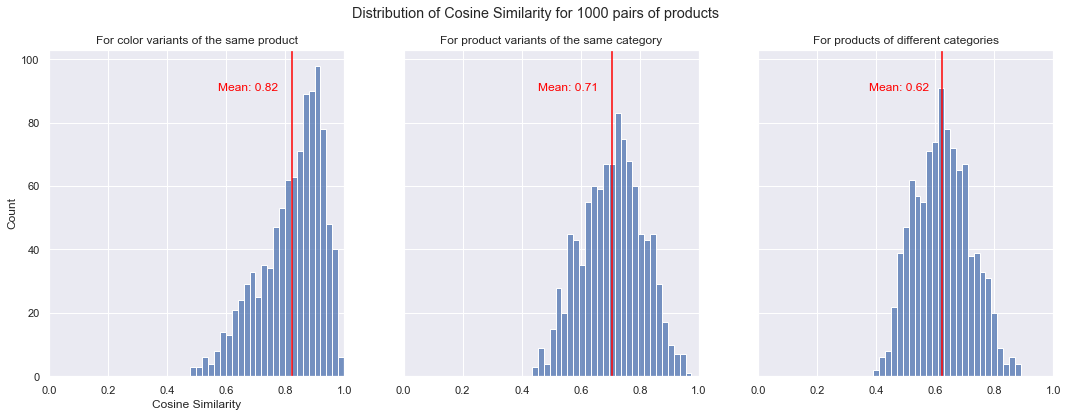

In [82]:
# Plot the distribution of the 3 groups and their cosine similarities
cosine_plot(group1_cos_sim, group2_cos_sim, group3_cos_sim,
            'For color variants of the same product',
            'For product variants of the same category',
            'For products of different categories')

This shows that the cosine similarity comparisons between color variants are the most similar with values closest to 1, and products in different categories have smaller cosine similarity values. 
In the preprocessing step, color variants will need to be treated as a cluster of the same product. 

In [83]:
combineddf.shape

(99332, 537)

In [84]:
# Save file as csv
combineddf.to_csv('/Users/pandabear/springboard/H_and_M_product_category_classification/data/interim/H_and_M_dataset.csv')
print('Saved to file')

Saved to file
